<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Вводная-к-этому-проекту" data-toc-modified-id="Вводная-к-этому-проекту-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Вводная к этому проекту</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Сравнение-эффективности-методов-на-сбалансированном-микро-сете" data-toc-modified-id="Сравнение-эффективности-методов-на-сбалансированном-микро-сете-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Сравнение эффективности методов на сбалансированном микро-сете</a></span></li><li><span><a href="#We-need-to-go-smaller" data-toc-modified-id="We-need-to-go-smaller-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>We need to go smaller</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Feature importance</a></span></li><li><span><a href="#class_weight-=-'balanced'" data-toc-modified-id="class_weight-=-'balanced'-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>class_weight = 'balanced'</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Вводная к этому проекту

Я решил принципиально сосредоточиться на модели RF, потому что мне поставили на работе задачу, непосредственно с ними связанную: мне, с их помощью, надо выявить feature importance для маленького дата-сета. Для этого я планирую использовать методы SHAP и LIME. К сожалению, чтобы не затягивать с и без того отстающей сдачей, и не возиться с совместимостью библиотек, в этом проекте я их использовать не смогу. Так что просто посмотрю, не меняется ли значимость с уменьшением дата-сета и использовании самого базового метода.

## Подготовка данных

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,7)})

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.inspection import permutation_importance

In [10]:
based = pd.read_csv('C:/Users/Aleksandr Ostudin/Documents/Python/Проекты Практикума/Command/Churn.csv')
display(based.head(10))
display(based.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

Персональные данные здесь ни к чему: модель они будут только сбивать, в попытках понять как уход из банка зависит от вашей фамилии. Устраняем их без доли сожаления, лишь удостоверившись, впрочем, что число клиентов в БД не вырожденное. 

In [11]:
print(len(based['CustomerId'].unique())==based.shape[0])
based = based.drop(['RowNumber','CustomerId','Surname'],axis=1)
display(based.tail(10))

True


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9990,714,Germany,Male,33,3.0,35016.60,1,1,0,53667.08,0
9991,597,France,Female,53,4.0,88381.21,1,1,0,69384.71,1
9992,726,Spain,Male,36,2.0,0.00,1,1,0,195192.40,0
9993,644,France,Male,28,7.0,155060.41,1,1,0,29179.52,0
9994,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


Здесь такой тонкий момент, что начав разбираться как заполнять пропуски всякими фэнси-эппроучами с proximity-matrix и иными приблудами я слегка заплутал. В итоге, даже вместо sklearn.impute.SimpleImputer, просто поставил вместо пропусков медианные значения, так как столбец такой только один, хоть и с ~10% пропусков.

In [12]:
based['Tenure'] = based['Tenure'].fillna(based['Tenure'].median())
display(based.tail(10))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9990,714,Germany,Male,33,3.0,35016.60,1,1,0,53667.08,0
9991,597,France,Female,53,4.0,88381.21,1,1,0,69384.71,1
9992,726,Spain,Male,36,2.0,0.00,1,1,0,195192.40,0
9993,644,France,Male,28,7.0,155060.41,1,1,0,29179.52,0
9994,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,792,France,Female,28,5.0,130142.79,1,1,0,38190.78,0


In [13]:
print(based['Geography'].unique())
print(based['Gender'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']


Поскольку категориальных совсем чуть-чуть, можно применять OHE без ужаса раздутия таблицы в лавкрафтовское чудовище. 

In [14]:
based = pd.get_dummies(data=based,columns=['Geography','Gender'], drop_first=True)
display(based.head(10))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
5,645,44,8.0,113755.78,2,1,0,149756.71,1,0,1,1
6,822,50,7.0,0.00,2,1,1,10062.80,0,0,0,1
7,376,29,4.0,115046.74,4,1,0,119346.88,1,1,0,0
8,501,44,4.0,142051.07,2,0,1,74940.50,0,0,0,1
9,684,27,2.0,134603.88,1,1,1,71725.73,0,0,0,1


In [15]:
y = based['Exited']
X = based.drop('Exited',axis=1)

Для Random Forest нет нужды нормализировать данные. Также, для RF деление идет на трейн-тест, без внешней валидационной выборки. Подбор гиперпараметров планируется вести двумя методами. Первый - без bootstrap, через RandomizedSearchCV, со внутренней кросс-валидацией, а второй через GridSearch, при использовании bootstrap. В этом случае метрикой является out-of-bag error. Рассмотрение обоих позволяет оценить bias-variance tradeoff для модели.

In [16]:
tree_X_train, tree_X_test, tree_y_train, tree_y_test = train_test_split(X,y, test_size=0.15, random_state=42)

In [17]:
tree = (tree_X_train, tree_X_test,tree_y_train, tree_y_test)

Очевидно, что классы сильно несбалансированы: число ушедших клиентов ~20%. Посмотрим точнее.

In [18]:
print(f'Class disbalance is: \n{y.value_counts(normalize=True)}')

Class disbalance is: 
0    0.7963
1    0.2037
Name: Exited, dtype: float64


## Исследование задачи

**Зададим все рабочие функции**

Execute прогоняет тест для модели и отображает требуемые выборки.

In [19]:
def execute(model,data,talk,draw):
    
    model_upd = model.fit(data[0],data[2])
    result = model_upd.predict(data[1])
    f1 = f1_score(data[3], result)
    yeerokk = roc_auc_score(data[3], model_upd.predict_proba(data[1])[:, 1])
    
    if talk == True:
        print(f'For selected model f1 is {f1.round(3)}')
        print(f'For selected model AUROC is {yeerokk.round(3)}')
    
    if draw == True:
        fpr, tpr, thresholds = roc_curve(data[3], result)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=yeerokk,
                                  estimator_name='selected_model')
        display.plot()
        plt.show()
    
    return model_upd

oob_grid ищет комбинации заданных гиперпараметров и, ну, хотя бы пытается оптимизироваться на сабсетах, не попавших в бутстреп-выборки. 

In [20]:
def oob_grid(data, look_for):

    oob_evolution = []
    best_score = 0
    best_grid = None
    best_rf_bs = None

    well_grown_rf_bs = RandomForestClassifier(bootstrap=True, oob_score=True, random_state=42)

    for choice in ParameterGrid(look_for):
            well_grown_rf_bs.set_params(**choice)
            well_grown_rf_bs.fit(data[0],data[2])
            oob_evolution.append(well_grown_rf_bs.oob_score_)
            if well_grown_rf_bs.oob_score_ > best_score:
                best_score = well_grown_rf_bs.oob_score_
                best_grid = choice
                best_rf_bs = well_grown_rf_bs
    
    print (f'Maximal OOB is {best_score.round(3)}')
    print (f'Grid is {best_grid}')
    
    plt.plot(oob_evolution)
    plt.show()

    return best_rf_bs

cv_rnd_grid пытается в то же самое, но на рандомизированном поиске, без бутстрэпа, с 4-fold кросс-валидацией по всему скормленному дата-сету.

In [21]:
def cv_rnd_grid(data,look_for):
    
    second_forest = RandomForestClassifier(bootstrap = False, random_state=42)
    
    #меняем скоринг с дефолтного на требуемый f1
    
    really_random = RandomizedSearchCV(estimator = second_forest, scoring = 'f1', param_distributions = look_for, n_iter = 100, cv = 4, random_state=42, n_jobs = -1)
    really_random.fit(data[0], data[2])

    desired_param_forest = really_random.best_params_
    well_grown_forest = really_random.best_estimator_

    print(f'Best grid is {desired_param_forest}')
    
    return well_grown_forest

**Запуск чистых моделей.**

For selected model f1 is 0.589
For selected model AUROC is 0.85


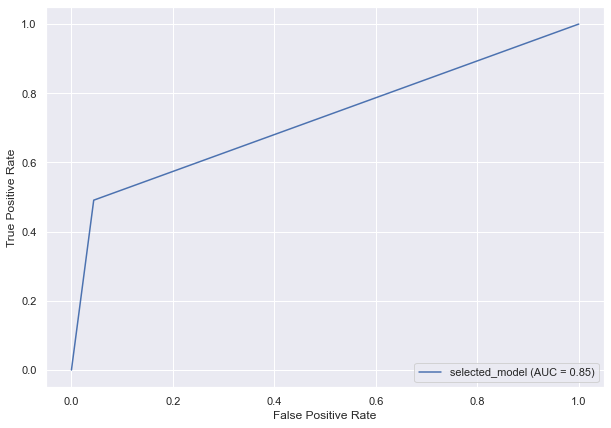

RandomForestClassifier(bootstrap=False, random_state=42)

In [22]:
wild_rf_full = RandomForestClassifier(bootstrap = False, random_state=42)
execute(model = wild_rf_full, data = tree, talk = True, draw = True)

For selected model f1 is 0.586
For selected model AUROC is 0.861


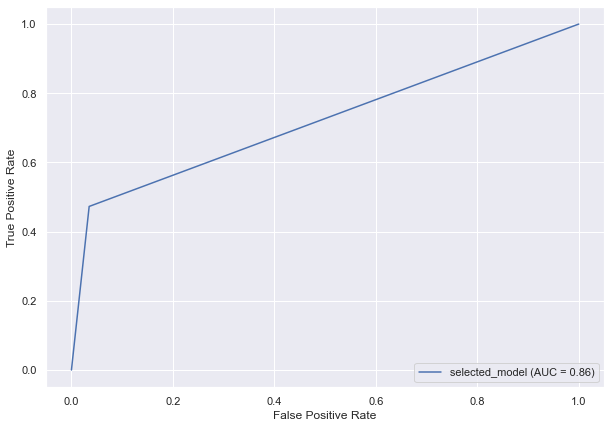

RandomForestClassifier(random_state=42)

In [23]:
wild_rf_bs = RandomForestClassifier(bootstrap = True, random_state=42)
execute(model = wild_rf_bs,data = tree, talk = True, draw = True)

**Попытка оптимизации гиперпараметров**

Если оставаться в рамках разумного, вообще вместо Grid надо было бы подобие Randomized, но и с ним бы полноценный расчёт был бы просто сумасшедшим в плане вычислительного объема, так что большая часть параметров оставлена дефолтной, а полноценно перебираются только число фич, используемых в агрегации, и число деревьев в ансамбле. 

In [24]:
max_features = ['auto', 0.3, 'log2']
n_estimators = list(range(100,300,10))

look_for = {'max_features': max_features,
            'n_estimators':n_estimators}

Maximal OOB is 0.862
Grid is {'max_features': 'auto', 'n_estimators': 410}


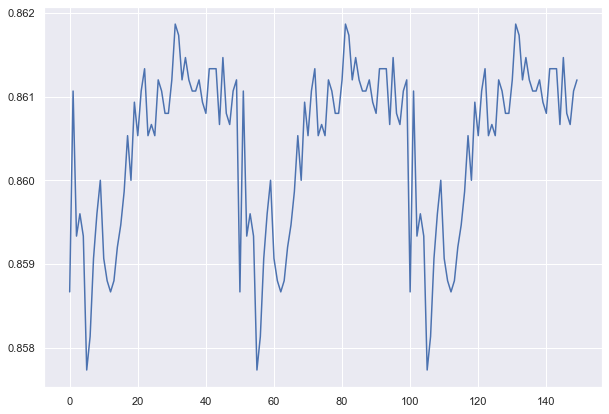

For selected model f1 is 0.595
For selected model AUROC is 0.864


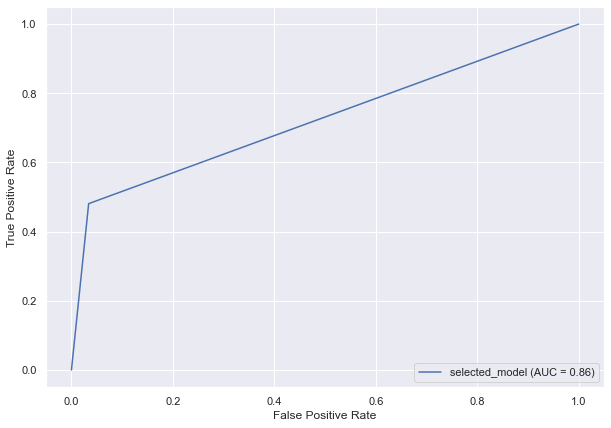

Wall time: 6min 26s


RandomForestClassifier(max_features='log2', n_estimators=590, oob_score=True,
                       random_state=42)

In [25]:
%%time

execute(model = oob_grid(tree, look_for), data = tree, talk = True, draw = True)

Best grid is {'n_estimators': 170, 'max_features': 'auto'}
For selected model f1 is 0.585
For selected model AUROC is 0.851


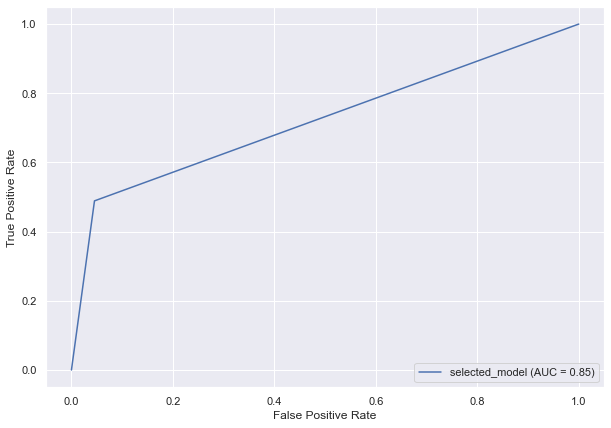

Wall time: 6min 21s


RandomForestClassifier(bootstrap=False, n_estimators=170, random_state=42)

In [26]:
%%time

execute(model = cv_rnd_grid(tree, look_for), data = tree, talk = True, draw = True)

**Подвывод**

1. На несбалансированных классах результаты довольно низкие. 
2. Попытка файн-тьюна гиперпараметров не увенчалась успехом: в обеих случаях результативность проседает. Варианта два. Либо модель сильно переобучается на валидах, либо так не фортануло, что исходные дефолты были лучше всего пространства предполагаемой "оптимизации". 
3. Поскольку число варьируемых параметров существенно увеличивает вычислительную нагрузку, полноценный "прогон" с радикальным улучшением на диване не замутишь. Даже CV пришлось ставить 4-fold. На работе у меня есть доступ к вычислительному кластеру, в следующих проектах я могу попробовать на нем посчитать 5-6 гиперов без мучительного ожидания. Другое дело, что у ревьюеров-то оно будет часов по 6-8 считаться все равно.. 

## Борьба с дисбалансом

**Вновь задаем вначале специфические функции, появляющиеся в этом разделе.**

upsample/downsample это бессовестные копии с материала курса.

In [27]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    #выделили где что в фичах
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    #выделили где что в таргетах
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    #объединили после умножения недостаточного класса
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)
    #перемешали
    
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    #выделили где что в фичах
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    #выделили где что в таргетах
    features_downsampled = pd.concat(
    [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
    [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    #объединили после ужатия избыточного класса
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=12345)
    #перемешали
    
    return features_downsampled, target_downsampled

Создадим соответствующие выборки.

In [28]:
X_up, y_up = upsample(tree_X_train, tree_y_train, 3)

X_red, y_red = downsample(tree_X_train, tree_y_train, 0.3)

In [29]:
tree_up = (X_up, tree_X_test, y_up, tree_y_test)
tree_red = (X_red, tree_X_test, y_red, tree_y_test)

**Запуск чистых моделей**

For selected model f1 is 0.58
For selected model AUROC is 0.848


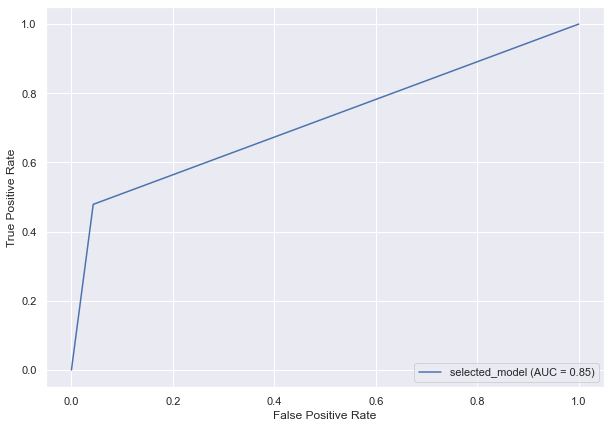

For selected model f1 is 0.582
For selected model AUROC is 0.854


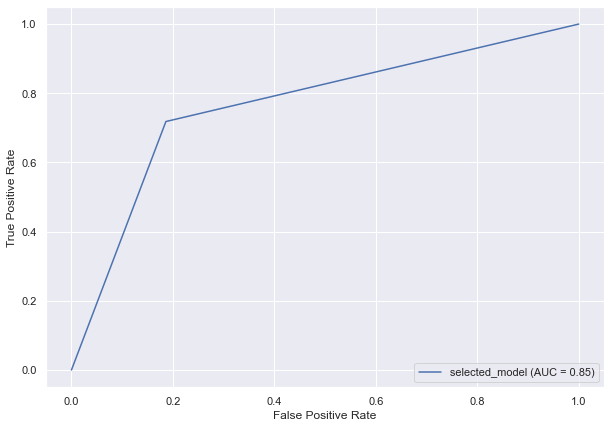

RandomForestClassifier(bootstrap=False, random_state=42)

In [30]:
wild_rf_full = RandomForestClassifier(bootstrap = False, random_state=42)
execute(model = wild_rf_full, data = tree_up, talk = True, draw = True)
execute(model = wild_rf_full, data = tree_red, talk = True, draw = True)

For selected model f1 is 0.613
For selected model AUROC is 0.858


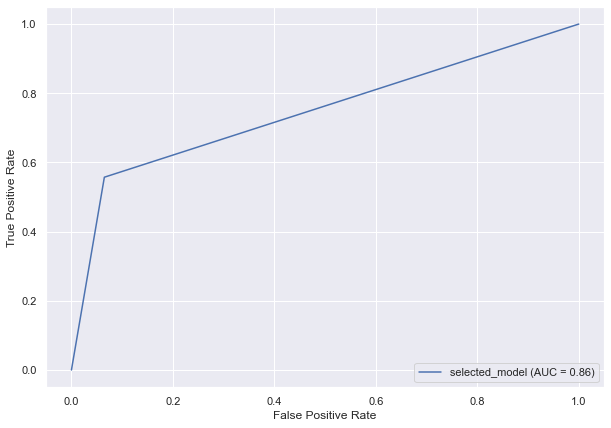

For selected model f1 is 0.603
For selected model AUROC is 0.86


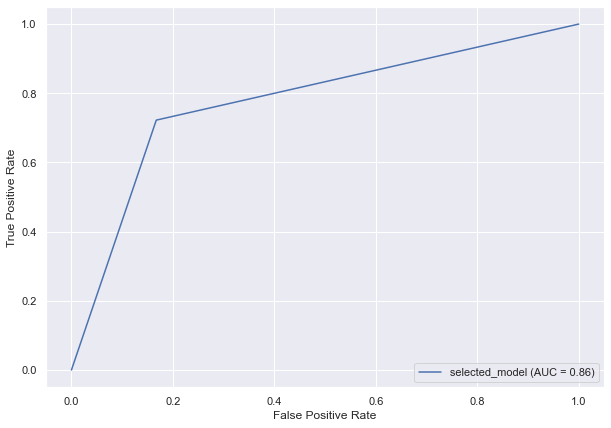

RandomForestClassifier(random_state=42)

In [31]:
wild_rf_bs = RandomForestClassifier(bootstrap = True, random_state=42)
execute(model = wild_rf_bs,data = tree_up, talk = True, draw = True)
execute(model = wild_rf_bs, data = tree_red, talk = True, draw = True)

**Посмотрим, получится ли оптимизировать на измененных выборках.**

Maximal OOB is 0.962
Grid is {'max_features': 'auto', 'n_estimators': 230}


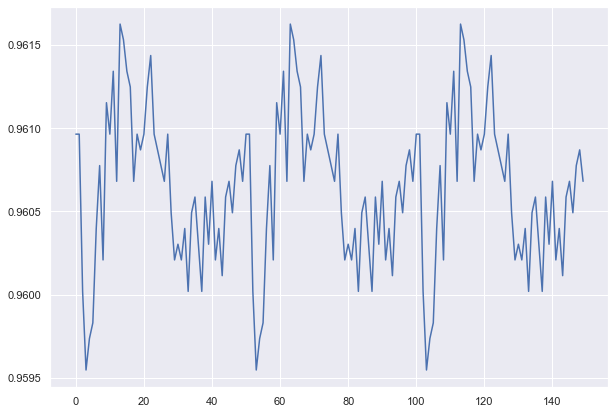

For selected model f1 is 0.607
For selected model AUROC is 0.862


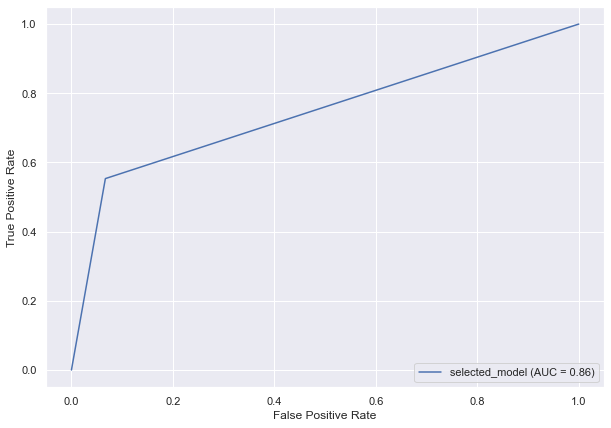

Best grid is {'n_estimators': 200, 'max_features': 'log2'}
For selected model f1 is 0.59
For selected model AUROC is 0.854


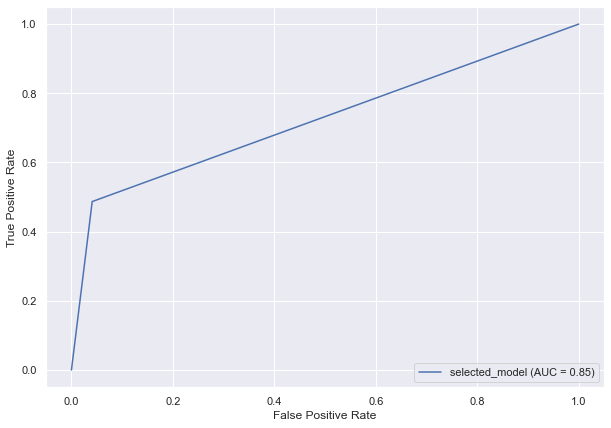

Wall time: 18min 10s


RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=200,
                       random_state=42)

In [32]:
%%time

execute(model = oob_grid(tree_up, look_for), data = tree_up, talk = True, draw = True)

execute(model = cv_rnd_grid(tree_up, look_for), data = tree_up, talk = True, draw = True)

Maximal OOB is 0.779
Grid is {'max_features': 'auto', 'n_estimators': 420}


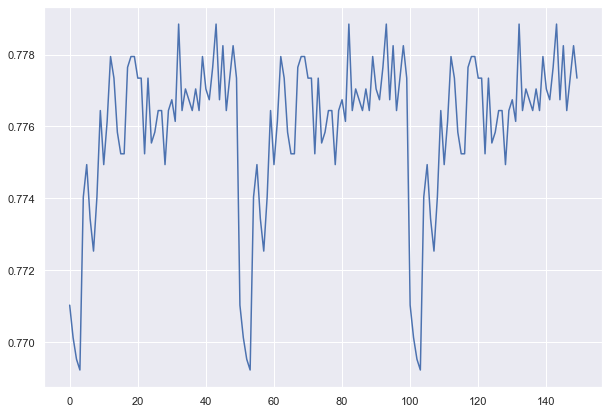

For selected model f1 is 0.599
For selected model AUROC is 0.862


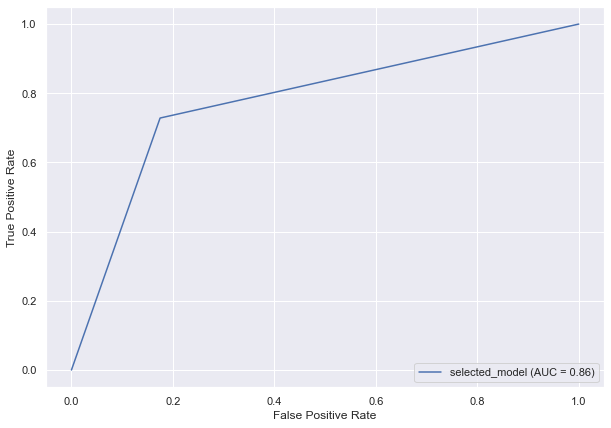

Best grid is {'n_estimators': 530, 'max_features': 'log2'}
For selected model f1 is 0.581
For selected model AUROC is 0.855


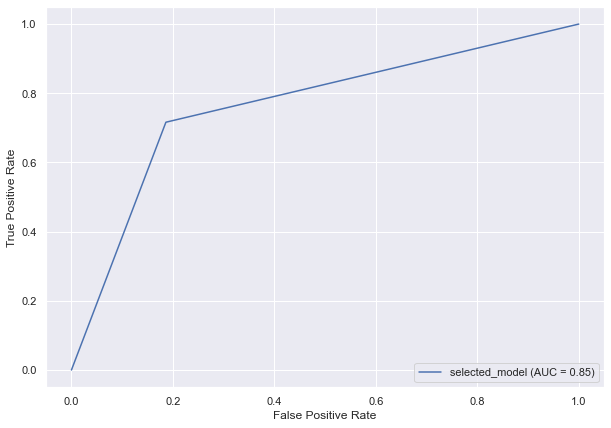

Wall time: 6min 54s


RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=530,
                       random_state=42)

In [33]:
%%time

execute(model = oob_grid(tree_red, look_for), data = tree_red, talk = True, draw = True)

execute(model = cv_rnd_grid(tree_red, look_for), data = tree_red, talk = True, draw = True)

**Подвывод**

1. После балансировки результаты - мое почтение. Приращивание выборки искусственными значениями помогает гораздо больше, чем урезание родной, но, в общем-то, это логично. Больше данных богу данных.
2. Опять же, значимо улучшить ситуацию относительно дефолтных значений не удалось, но, впрочем, и ухудшить тоже, так что прогресс, хоть и относительный.
3. Значимо улучшается также и AUC-ROC, практически приближаясь к идеальному классифайеру. Если для предыдущих еще имело смысл подбирать какой-то threshold по FPR, исходя из бузнес-логики, то с этими можно прям смело ****як**-****як** - и в продакшн!

## Сравнение эффективности методов на сбалансированном микро-сете

Но. Что, если попробовать провернуть ту же операцию, но на маленьком дата-сете? Какой способ покажет себя лучше?

Зададим соответствующий дата-сет в 150 значений размером.

In [34]:
baby_X = X_up.sample(frac=0.011, random_state=42)
baby_y = y_up.sample(frac=0.011, random_state=42)

display(baby_X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 8438 to 3593
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        116 non-null    int64  
 1   Age                116 non-null    int64  
 2   Tenure             116 non-null    float64
 3   Balance            116 non-null    float64
 4   NumOfProducts      116 non-null    int64  
 5   HasCrCard          116 non-null    int64  
 6   IsActiveMember     116 non-null    int64  
 7   EstimatedSalary    116 non-null    float64
 8   Geography_Germany  116 non-null    uint8  
 9   Geography_Spain    116 non-null    uint8  
 10  Gender_Male        116 non-null    uint8  
dtypes: float64(3), int64(5), uint8(3)
memory usage: 8.5 KB


None

In [35]:
baby = (baby_X, tree_X_test, baby_y, tree_y_test)

**Чистые модели**

For selected model f1 is 0.518
For selected model AUROC is 0.784


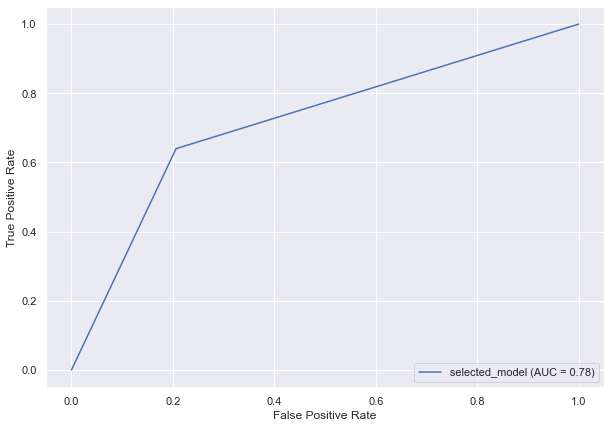

RandomForestClassifier(bootstrap=False, random_state=42)

In [36]:
wild_rf_full = RandomForestClassifier(bootstrap = False, random_state=42)
execute(model = wild_rf_full, data = baby, talk = True, draw = True)

For selected model f1 is 0.533
For selected model AUROC is 0.787


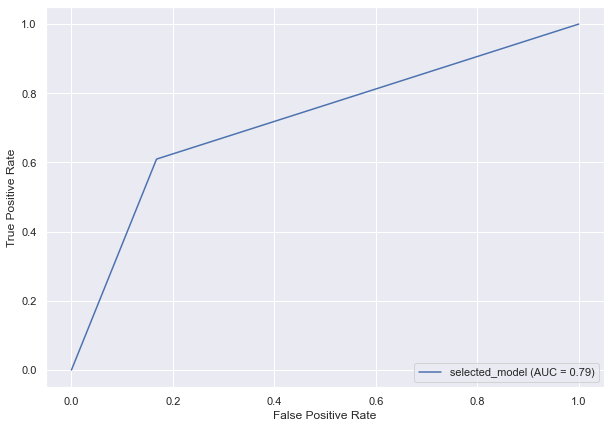

RandomForestClassifier(random_state=42)

In [37]:
wild_rf_bs = RandomForestClassifier(bootstrap = True, random_state=42)
execute(model = wild_rf_bs,data = baby, talk = True, draw = True)

**(((Оптимизация)))**

Maximal OOB is 0.75
Grid is {'max_features': 'auto', 'n_estimators': 470}


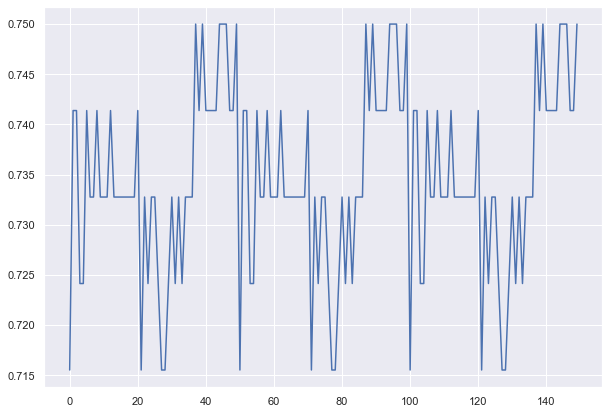

For selected model f1 is 0.543
For selected model AUROC is 0.797


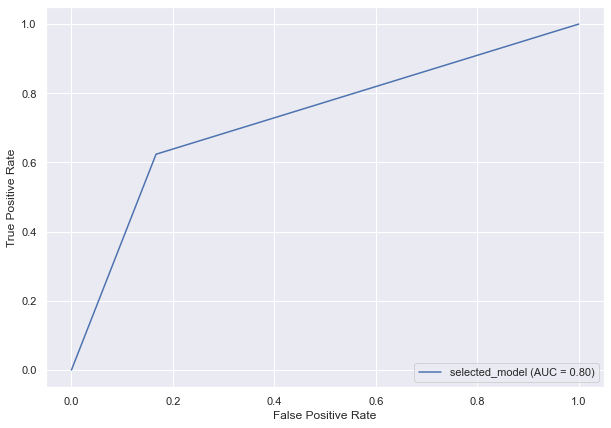

Best grid is {'n_estimators': 460, 'max_features': 'auto'}
For selected model f1 is 0.527
For selected model AUROC is 0.788


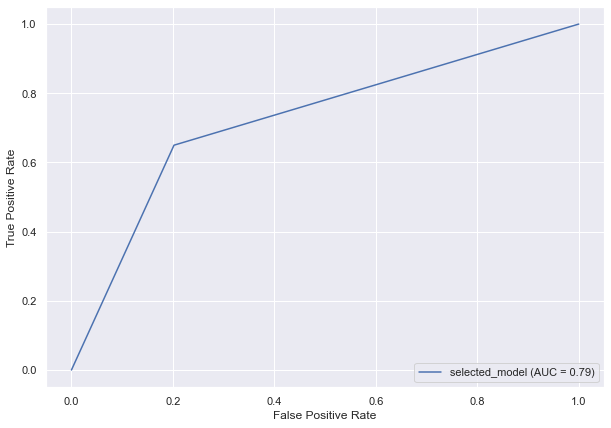

Wall time: 1min 46s


RandomForestClassifier(bootstrap=False, n_estimators=460, random_state=42)

In [38]:
%%time

execute(model = oob_grid(baby, look_for), data = baby, talk = True, draw = True)

execute(model = cv_rnd_grid(baby, look_for), data = baby, talk = True, draw = True)

**Подвывод**

А вот тут уже разница от оптимизации положительная, так как AUC-ROC вырос почти на 1%! То есть классифайер стал хоть капельку, но сильнее. Ну и, опять же, в условиях маленькой выборки бутстрэп значимо outperforming. Хотя общий результат падает достаточно серьезно. 

UPD. Поставил полноразмерную выборку. Получился так себе результат, но вот тут оптимизация дотянула на 10%, почти до результата модели, обученной на большом тренировочном дата-сете. 

## We need to go smaller

В случае моей работы дата-сет должен стремиться к минимуму, так как там дорогие физические данные. Попробуем прогнать задачу на совсем маленьком сете, уже только с бутстрэпом.

In [39]:
nano_X = X_up.sample(frac=0.003, random_state=42)
nano_y = y_up.sample(frac=0.003, random_state=42)

display(nano_X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 8438 to 7740
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        32 non-null     int64  
 1   Age                32 non-null     int64  
 2   Tenure             32 non-null     float64
 3   Balance            32 non-null     float64
 4   NumOfProducts      32 non-null     int64  
 5   HasCrCard          32 non-null     int64  
 6   IsActiveMember     32 non-null     int64  
 7   EstimatedSalary    32 non-null     float64
 8   Geography_Germany  32 non-null     uint8  
 9   Geography_Spain    32 non-null     uint8  
 10  Gender_Male        32 non-null     uint8  
dtypes: float64(3), int64(5), uint8(3)
memory usage: 2.3 KB


None

In [40]:
wild_rf_bs = RandomForestClassifier(bootstrap = True, oob_score=True, random_state=42)

for i in range(6):
    
    nano_X_test = X_up.sample(frac=0.003, random_state=i)
    nano_y_test = y_up.sample(frac=0.003, random_state=i)
    
    nano = (nano_X, nano_X_test,nano_y,nano_y_test)
    
    execute(model = wild_rf_bs, data = nano, talk = True, draw = False)

For selected model f1 is 0.605
For selected model AUROC is 0.496
For selected model f1 is 0.45
For selected model AUROC is 0.523
For selected model f1 is 0.432
For selected model AUROC is 0.409
For selected model f1 is 0.513
For selected model AUROC is 0.48
For selected model f1 is 0.6
For selected model AUROC is 0.704
For selected model f1 is 0.55
For selected model AUROC is 0.583


In [41]:
nano_upd = (nano_X, tree_X_test, nano_y, tree_y_test)

For selected model f1 is 0.308
For selected model AUROC is 0.522


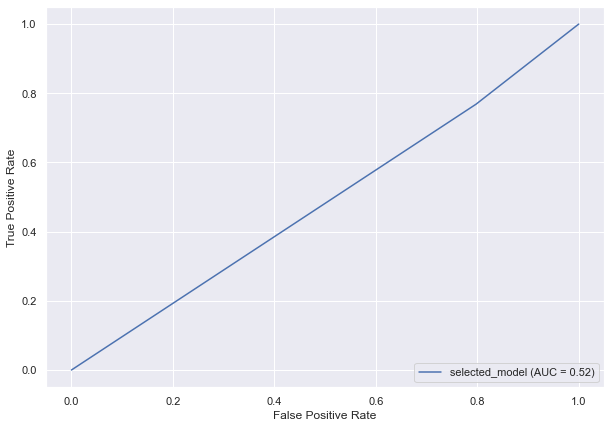

RandomForestClassifier(oob_score=True, random_state=42)

In [42]:
execute(model = wild_rf_bs, data = nano_upd, talk = True, draw = True)

**Комментарий:** Без комментариев

In [43]:
%%time

max_features = [0.3, 'log2']
n_estimators = list(range(100,600,10))
max_depth = list(range(2,6))
min_samples_leaf = list(range(2,6))
min_samples_split = list(range(2,6))

more_data = {'max_features': max_features,
            'n_estimators':n_estimators,
            'max_depth':max_depth,
            'min_samples_leaf':min_samples_leaf,
            'min_samples_split':min_samples_split}

#здесь пришлось капельку скостылить

bonsai = oob_grid(data = (nano_X, 'filler',nano_y),look_for = more_data)

for i in range(6):
    
    nano_X_test = X_up.sample(frac=0.003, random_state=i)
    nano_y_test = y_up.sample(frac=0.003, random_state=i)
    
    nano = (nano_X, nano_X_test,nano_y,nano_y_test)
    
    execute(model = bonsai, data = nano, talk = True, draw = False)

KeyboardInterrupt: 

Как итог, мы получаем, что для нано-сета оптимизация по всем гиперпараметрам опять провалилась. Средний f1 для чистого 0.666, а для бoнсая - 0.626, AUROC 0.735 и 0.719, соответственно. Попробуем прогнать по обычному, урезанному набору самых важных: возможно, дерево с ограничениями на гиперы, получается хуже именно потому что интервалы ограничений не слишком обширные, и лучше бы их и вовсе не было. 

**UPD.** Цифры поменялись, суть не особо

Maximal OOB is 0.688
Grid is {'max_features': 'auto', 'n_estimators': 180}


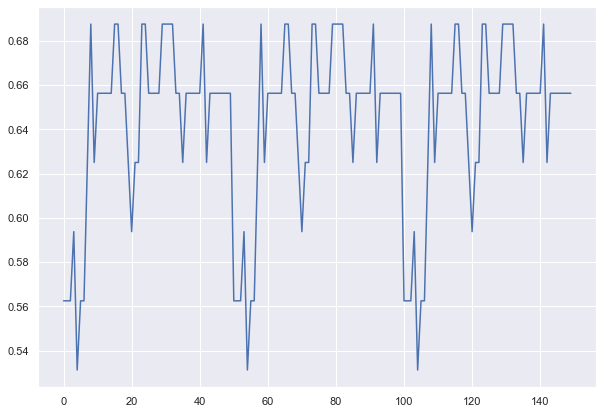

For selected model f1 is 0.605
For selected model AUROC is 0.514
For selected model f1 is 0.45
For selected model AUROC is 0.532
For selected model f1 is 0.444
For selected model AUROC is 0.462
For selected model f1 is 0.513
For selected model AUROC is 0.466
For selected model f1 is 0.615
For selected model AUROC is 0.731
For selected model f1 is 0.585
For selected model AUROC is 0.563
Wall time: 1min 10s


In [44]:
%%time

max_features = ['auto', 0.3, 'log2']
n_estimators = list(range(100,600,10))

less_data = {'max_features': max_features,
            'n_estimators':n_estimators}

#здесь пришлось капельку скостылить

bansai = oob_grid(data = (nano_X, 'filler',nano_y),look_for = less_data)

for i in range(6):
    
    nano_X_test = X_up.sample(frac=0.003, random_state=i)
    nano_y_test = y_up.sample(frac=0.003, random_state=i)
    
    nano = (nano_X, nano_X_test,nano_y,nano_y_test)
    
    execute(model = bansai, data = nano, talk = True, draw = False)

С f1=0.635 и AUROC=0.73 результат улучшился. Возможно, для маленького набора данных, меньшее число деревьев даст лучший результат? 

Maximal OOB is 0.625
Grid is {'max_features': 'auto', 'n_estimators': 56}


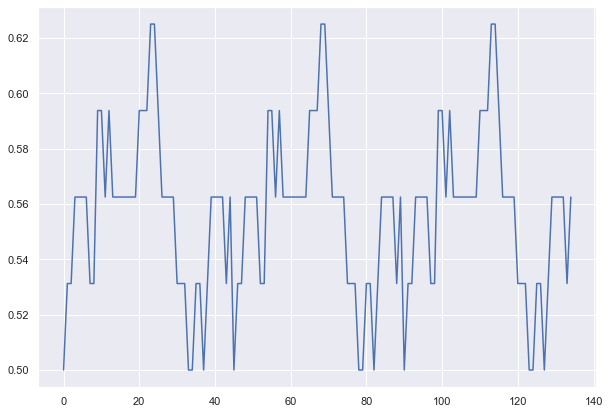

For selected model f1 is 0.605
For selected model AUROC is 0.504
For selected model f1 is 0.45
For selected model AUROC is 0.525
For selected model f1 is 0.432
For selected model AUROC is 0.407
For selected model f1 is 0.513
For selected model AUROC is 0.488
For selected model f1 is 0.6
For selected model AUROC is 0.702
For selected model f1 is 0.55
For selected model AUROC is 0.587
Wall time: 9.8 s


In [45]:
%%time

max_features = ['auto', 0.3, 'log2']
n_estimators = list(range(10,100,2))

less_trees = {'max_features': max_features,
            'n_estimators':n_estimators}

#здесь пришлось капельку скостылить

bonsai = oob_grid(data = (nano_X, 'filler',nano_y),look_for = less_trees)

for i in range(6):
    
    nano_X_test = X_up.sample(frac=0.003, random_state=i)
    nano_y_test = y_up.sample(frac=0.003, random_state=i)
    
    nano = (nano_X, nano_X_test,nano_y,nano_y_test)
    
    execute(model = bonsai, data = nano, talk = True, draw = False)

C f1 = 0.664 и AUROC = 0.737 такой прогон уже обошел по второй метрике чистую модель. После я попробовал еще меньше, но такая модель уже начала терять смысл, и немного улучшив f1 сильно уронила AUROC. Также я попробовал такой прогон на дата-сете baby, со 150 значениями, но там выраженного положительного эффекта от снижения числа деревьев не наблюдалось.

Таким образом, получил занятную гипотезу, что в случае экстремально маленького дата-сета с бутстрепом большое число деревьев начинает буквально повторять друг друга, что приводит к overcorrelation и снижению результативности. В интернете нашел не так много по теме пока, постараюсь еще вникнуть.

For selected model f1 is 0.292
For selected model AUROC is 0.486


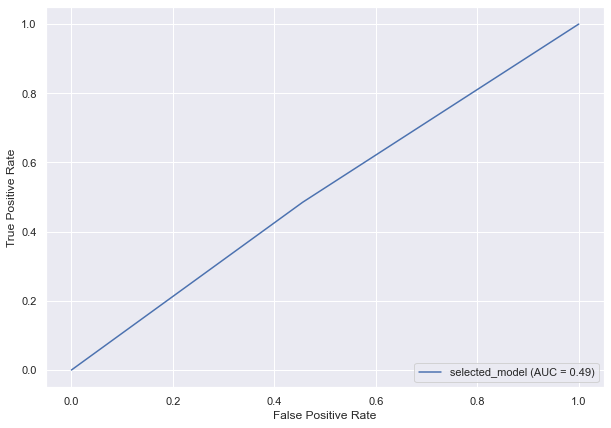

For selected model f1 is 0.563
For selected model AUROC is 0.496


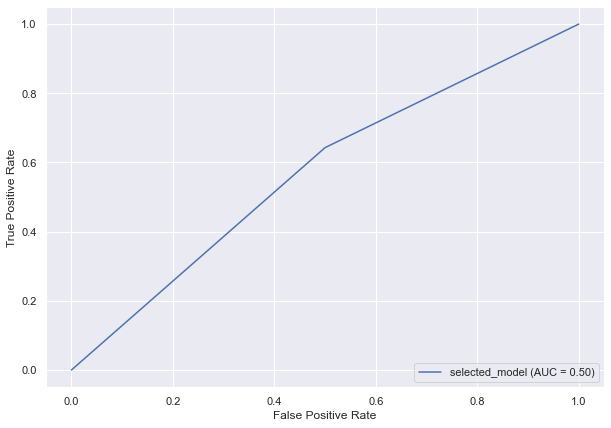

DummyClassifier(strategy='stratified')

In [46]:
dumbass = DummyClassifier(strategy = 'stratified')
execute(model = dumbass, data = baby, talk = True, draw = True)
execute(model = dumbass, data = nano, talk = True, draw = True)

Обе модели, для baby и nano, успешно прошли sanity-check, работая лучше случайной модели.

## Feature importance

Собственно, в силу дороговизны данных, как раз и важно понять следующее: как сильно изменение параметра влияет на конкретный дата-сет, чтобы работать, в большей мере, именно с ним.

In [47]:
oak = RandomForestClassifier(bootstrap = True, random_state=42, max_features = 'auto', n_estimators = 550)
oak_trained = execute(model = oak, data = tree_up, talk = False, draw = False)
display(pd.Series(data = permutation_importance(oak_trained, tree_up[0], tree_up[2], n_repeats=10, random_state=42).importances_mean, index=tree_up[0].columns).sort_values(ascending=False))

Age                  0.246645
NumOfProducts        0.178733
Balance              0.134461
IsActiveMember       0.130397
Geography_Germany    0.103762
Gender_Male          0.078866
EstimatedSalary      0.055388
CreditScore          0.049121
Tenure               0.032316
Geography_Spain      0.018081
HasCrCard            0.007590
dtype: float64

In [48]:
rose = RandomForestClassifier(bootstrap = True, random_state=42, max_features = 'auto', n_estimators = 370)
rose_trained = execute(model = rose, data = baby, talk = False, draw = False)
display(pd.Series(data = permutation_importance(rose_trained, baby[0], baby[2], n_repeats=10, random_state=42).importances_mean, index=baby[0].columns).sort_values(ascending=False))

Age                  0.200000
IsActiveMember       0.056897
Balance              0.046552
EstimatedSalary      0.028448
NumOfProducts        0.014655
CreditScore          0.014655
Tenure               0.006034
HasCrCard            0.000000
Geography_Germany    0.000000
Geography_Spain      0.000000
Gender_Male          0.000000
dtype: float64

In [49]:
bonsai = RandomForestClassifier(bootstrap = True, random_state=42, max_features = 'auto', n_estimators = 48)
bonsai_trained = execute(model = bonsai, data = nano, talk = False, draw = False)
display(pd.Series(data = permutation_importance(bonsai_trained, nano[0], nano[2], n_repeats=10, random_state=42).importances_mean, index=nano[0].columns).sort_values(ascending=False))

Balance              0.162500
NumOfProducts        0.059375
Age                  0.009375
EstimatedSalary      0.009375
CreditScore          0.006250
Tenure               0.006250
HasCrCard            0.000000
IsActiveMember       0.000000
Geography_Germany    0.000000
Geography_Spain      0.000000
Gender_Male          0.000000
dtype: float64

Важным выводом является то, что ключевой признак определяется даже при дата-сете в 240 раз меньше оригинального. Но вот с общей точностью, конечно, в таком случае проблемы, ведь просто недостаточно примеров может попасть в обозреваемый сет. 

Поскольку везде возраст значим, давайте еще и какую-то бизнес-рекомендацию выдадим: посмотрим на средний возраст и счёт уходящих и остающихся.

In [50]:
stay_age = based.loc[based['Exited']==0,'Age'].mean()
leave_age = based.loc[based['Exited']==1,'Age'].mean()

stay_m = based.loc[based['Exited']==0,'Balance'].mean()
leave_m = based.loc[based['Exited']==1,'Balance'].mean()

print(f'Stay is {stay_age.round(1)} yrs old, leave is {leave_age.round(1)} yrs old')
print(f'Stay is {stay_m.round(2)} euro, leave is {leave_m.round(2)} euro')

AttributeError: 'float' object has no attribute 'round'

Похоже, что у Бета-Банка серьезные проблемы с немецкими пенсионерами, выводящими свои рейхсмарки! Солидная публика, за такую имеет смысл побороться.

In [ ]:
wild_rf_bs = RandomForestClassifier(bootstrap = True, class_weight='balanced', random_state=42)
execute(model = wild_rf_bs,data = tree, talk = True, draw = True)

Пришлось перезадать функцию для простоты выполнения.

In [ ]:
def oob_grid_weight(data, look_for):

    oob_evolution = []
    best_score = 0
    best_grid = None
    best_rf_bs = None

    well_grown_rf_bs = RandomForestClassifier(bootstrap=True, oob_score=True, class_weight='balanced', random_state=42)

    for choice in ParameterGrid(look_for):
            well_grown_rf_bs.set_params(**choice)
            well_grown_rf_bs.fit(data[0],data[2])
            oob_evolution.append(well_grown_rf_bs.oob_score_)
            if well_grown_rf_bs.oob_score_ > best_score:
                best_score = well_grown_rf_bs.oob_score_
                best_grid = choice
                best_rf_bs = well_grown_rf_bs
    
    print (f'Maximal OOB is {best_score.round(3)}')
    print (f'Grid is {best_grid}')
    
    plt.plot(oob_evolution)
    plt.show()

    return best_rf_bs

In [ ]:
%%time

execute(model = oob_grid_weight(tree, look_for), data = tree, talk = True, draw = True)

## Общий вывод

1. Терпение и труд - все я устал. 
2. Все поставленные в ТЗ задачи достигнуты. **UPD.** Лучшим методом борьбы с дисбалансом проявил себя upsampling. Наилучшая модель на сбалансированном дата-сете - дефолтная, использующая бутстрэп, максимальные показатели: f1 = 0.613, AUROC = 0.858. 
3. Никак не получается у меня освоить хоть какой-то способ оптимизации гиперпараметров: как не крути, модели после вроде бы файн-тьюна лучше не получаются. 
4. Впервые в жизни столкнулся с тем, что компухтер не моментально исполняет твои барские пожелания.
5. Изучил, как работают деревья в случае экстремально-маленьких дата-сетов, что важно для моей работы, где сразу побегу знания внедрять, но все еще остается без ответа ряд гипотез. 

Буду рад фидбэку и споесба вам за внимание <3

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*